In this notebook, you will learn optimization techniques on the subject of Santa-2024 competition.<br>
santa-2024のコンペを題材に、最適化手法を学んでいきます。<br>
1. [Issues in Competition (コンペにおける課題)](https://www.kaggle.com/code/utm529fg/eng-tutolial-1-issues-in-competitions)
2. [Greedy (貪欲法)](https://www.kaggle.com/code/utm529fg/eng-tutolial-2-greedy)
3. BS: Beam Search (ビームサーチ) ← this notebook
4. HC: Hill Climbing (山登り法)
5. SA: Simulated Annealing (焼きなまし法)
6. GA: Genetic Algorithm (遺伝的アルゴリズム)

# 3-1. What's Beam Search Algrithm　ビームサーチとは
In the previous greedy tutorial, the idea was to decide on a sequence of 10 words, one word at a time, in order from the top to the bottom to maximize the score. In beam search, we do not settle on a single word, but keep, for example, the top three candidates and move on to the next word.<br>
The number of top candidates is called the beam width.
The algorithm is as follows.<br>
**Step 1**. Decide the `beam_width`.<br>
**Step 2**. Calculate the perplexity score for one word only.<br>
**Step 3**. The top scoring `beam_width` words are tentative text candidates.<br>
**Step 4**. Calculate the two-word perplexity score for each of the remaining candidate words as the second word.<br>
**Step 5**. The top `beam_width` words with the best scores are selected as tentative text candidates. step6.<br>
**Step 6**. Repeat steps 4-5, increasing the number of words one by one.<br>
The larger the beam_width, the more text is left as candidates, which increases the computation time, but the better the score is expected to be.<br>

前回の貪欲法では、10個の単語の並びを頭から順にスコアが最大になるように1単語ずつ決めていくという考え方でした。
ビームサーチでは、1単語に決めず、例えば上位3つまで候補を残して、次の単語の検討に移ります。<br>
上位何個まで残すかの数値を、ビーム幅と呼びます。<br>
以下のようなアルゴリズムです。<br>
**Step 1**. ビーム幅 `beam_width` を決める。<br>
**Step 2**. 1単語のみで、perplexityスコアを計算する。<br>
**Step 3**. スコアの良い上位 `beam_width` 個の単語を暫定のテキスト候補とする。<br>
**Step 4**. 候補に残りの単語をそれぞれ2番目の単語とした時の、2単語でのperplexityスコアを計算する。<br>
**Step 5**. スコアの良い上位 `beam_width` 個のテキストを暫定のテキスト候補とする。<br>
**Step 6**. 4-5の手順を単語数の数だけ一つずつ増やしながら繰り返す。<br>
ビーム幅を大きくするほど、候補として残すテキストが増えるため、計算時間は増えますが、スコアは良くなることが期待できます。

# 3-2. Implementation 実装

In [1]:
"""Evaluation metric for Santa 2024."""

import gc
import os
from math import exp
from collections import Counter
from typing import List, Optional, Union

import numpy as np
import pandas as pd
import transformers
import torch

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
PAD_TOKEN_LABEL_ID = torch.nn.CrossEntropyLoss().ignore_index
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class ParticipantVisibleError(Exception):
    pass


def score(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    row_id_column_name: str,
    model_path: str = '/kaggle/input/gemma-2/transformers/gemma-2-9b/2',
    load_in_8bit: bool = False,
    clear_mem: bool = False,
) -> float:
    """
    Calculates the mean perplexity of submitted text permutations compared to an original text.

    Parameters
    ----------
    solution : DataFrame
        DataFrame containing the original text in a column named 'text'.
        Includes a row ID column specified by `row_id_column_name`.

    submission : DataFrame
        DataFrame containing the permuted text in a column named 'text'.
        Must have the same row IDs as the solution.
        Includes a row ID column specified by `row_id_column_name`.

    row_id_column_name : str
        Name of the column containing row IDs.
        Ensures aligned comparison between solution and submission.

    model_path : str, default='/kaggle/input/gemma-2/transformers/gemma-2-9b/2'
        Path to the serialized LLM.

    load_in_8bit : bool, default=False
        Use 8-bit quantization for the model. Requires CUDA.

    clear_mem : bool, default=False
        Clear GPU memory after scoring by clearing the CUDA cache.
        Useful for testing.

    Returns
    -------
    float
        The mean perplexity score. Lower is better.

    Raises
    ------
    ParticipantVisibleError
        If the submission format is invalid or submitted strings are not valid permutations.

    Examples
    --------
    >>> import pandas as pd
    >>> model_path = "/kaggle/input/gemma-2/transformers/gemma-2-9b/2"
    >>> solution = pd.DataFrame({
    ...     'id': [0, 1],
    ...     'text': ["this is a normal english sentence", "the quick brown fox jumps over the lazy dog"]
    ... })
    >>> submission = pd.DataFrame({
    ...     'id': [0, 1],
    ...     'text': ["sentence english normal a is this", "lazy the over jumps fox brown quick the dog"]
    ... })
    >>> score(solution, submission, 'id', model_path=model_path, clear_mem=True) > 0
    True
    """
    # Check that each submitted string is a permutation of the solution string
    sol_counts = solution.loc[:, 'text'].str.split().apply(Counter)
    sub_counts = submission.loc[:, 'text'].str.split().apply(Counter)
    invalid_mask = sol_counts != sub_counts
    if invalid_mask.any():
        raise ParticipantVisibleError(
            'At least one submitted string is not a valid permutation of the solution string.'
        )

    # Calculate perplexity for the submitted strings
    sub_strings = [
        ' '.join(s.split()) for s in submission['text'].tolist()
    ]  # Split and rejoin to normalize whitespace
    scorer = PerplexityCalculator(
        model_path=model_path,
        load_in_8bit=load_in_8bit,
    )  # Initialize the perplexity calculator with a pre-trained model
    perplexities = scorer.get_perplexity(
        sub_strings
    )  # Calculate perplexity for each submitted string

    if clear_mem:
        # Just move on if it fails. Not essential if we have the score.
        try:
            scorer.clear_gpu_memory()
        except:
            print('GPU memory clearing failed.')

    return float(np.mean(perplexities))


class PerplexityCalculator:
    """
    Calculates perplexity of text using a pre-trained language model.

    Adapted from https://github.com/asahi417/lmppl/blob/main/lmppl/ppl_recurrent_lm.py

    Parameters
    ----------
    model_path : str
        Path to the pre-trained language model

    load_in_8bit : bool, default=False
        Use 8-bit quantization for the model. Requires CUDA.

    device_map : str, default="auto"
        Device mapping for the model.
    """

    def __init__(
        self,
        model_path: str,
        load_in_8bit: bool = False,
        device_map: str = 'auto',
    ):
        self.tokenizer = transformers.AutoTokenizer.from_pretrained(model_path)
        # Configure model loading based on quantization setting and device availability
        if load_in_8bit:
            if DEVICE.type != 'cuda':
                raise ValueError('8-bit quantization requires CUDA device')
            quantization_config = transformers.BitsAndBytesConfig(load_in_8bit=True)
            self.model = transformers.AutoModelForCausalLM.from_pretrained(
                model_path,
                quantization_config=quantization_config,
                device_map=device_map,
            )
        else:
            self.model = transformers.AutoModelForCausalLM.from_pretrained(
                model_path,
                torch_dtype=torch.float16 if DEVICE.type == 'cuda' else torch.float32,
                device_map=device_map,
            )

        self.loss_fct = torch.nn.CrossEntropyLoss(reduction='none')

        self.model.eval()

    def get_perplexity(
        self, input_texts: Union[str, List[str]], debug=False
    ) -> Union[float, List[float]]:
        """
        Calculates the perplexity of given texts.

        Parameters
        ----------
        input_texts : str or list of str
            A single string or a list of strings.

        batch_size : int, default=None
            Batch size for processing. Defaults to the number of input texts.

        debug : bool, default=False
            Print debugging information.

        Returns
        -------
        float or list of float
            A single perplexity value if input is a single string,
            or a list of perplexity values if input is a list of strings.

        Examples
        --------
        >>> import pandas as pd
        >>> model_path = "/kaggle/input/gemma-2/transformers/gemma-2-9b/2"
        >>> scorer = PerplexityCalculator(model_path=model_path)

        >>> submission = pd.DataFrame({
        ...     'id': [0, 1, 2],
        ...     'text': ["this is a normal english sentence", "thsi is a slihgtly misspelled zr4g sentense", "the quick brown fox jumps over the lazy dog"]
        ... })
        >>> perplexities = scorer.get_perplexity(submission["text"].tolist())
        >>> perplexities[0] < perplexities[1]
        True
        >>> perplexities[2] < perplexities[0]
        True

        >>> perplexities = scorer.get_perplexity(["this is a sentence", "another sentence"])
        >>> all(p > 0 for p in perplexities)
        True

        >>> scorer.clear_gpu_memory()
        """
        single_input = isinstance(input_texts, str)
        input_texts = [input_texts] if single_input else input_texts

        loss_list = []
        with torch.no_grad():
            # Process each sequence independently
            for text in input_texts:
                # Explicitly add sequence boundary tokens to the text
                text_with_special = f"{self.tokenizer.bos_token}{text}{self.tokenizer.eos_token}"

                # Tokenize
                model_inputs = self.tokenizer(
                    text_with_special,
                    return_tensors='pt',
                    add_special_tokens=False,
                )

                if 'token_type_ids' in model_inputs:
                    model_inputs.pop('token_type_ids')

                model_inputs = {k: v.to(DEVICE) for k, v in model_inputs.items()}

                # Get model output
                output = self.model(**model_inputs, use_cache=False)
                logits = output['logits']

                # Shift logits and labels for calculating loss
                shift_logits = logits[..., :-1, :].contiguous()  # Drop last prediction
                shift_labels = model_inputs['input_ids'][..., 1:].contiguous()  # Drop first input

                # Calculate token-wise loss
                loss = self.loss_fct(
                    shift_logits.view(-1, shift_logits.size(-1)),
                    shift_labels.view(-1)
                )

                # Calculate average loss
                sequence_loss = loss.sum() / len(loss)
                loss_list.append(sequence_loss.cpu().item())

                # Debug output
                if debug:
                    print(f"\nProcessing: '{text}'")
                    print(f"With special tokens: '{text_with_special}'")
                    print(f"Input tokens: {model_inputs['input_ids'][0].tolist()}")
                    print(f"Target tokens: {shift_labels[0].tolist()}")
                    print(f"Input decoded: {self.tokenizer.decode(model_inputs['input_ids'][0])}")
                    print(f"Target decoded: {self.tokenizer.decode(shift_labels[0])}")
                    print(f"Individual losses: {loss.tolist()}")
                    print(f"Average loss: {sequence_loss.item():.4f}")

        ppl = [exp(i) for i in loss_list]

        if debug:
            print("\nFinal perplexities:")
            for text, perp in zip(input_texts, ppl):
                print(f"Text: '{text}'")
                print(f"Perplexity: {perp:.2f}")

        return ppl[0] if single_input else ppl

    def clear_gpu_memory(self) -> None:
        """Clears GPU memory by deleting references and emptying caches."""
        if not torch.cuda.is_available():
            return

        # Delete model and tokenizer if they exist
        if hasattr(self, 'model'):
            del self.model
        if hasattr(self, 'tokenizer'):
            del self.tokenizer

        # Run garbage collection
        gc.collect()

        # Clear CUDA cache and reset memory stats
        with DEVICE:
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
            torch.cuda.reset_peak_memory_stats()

In [2]:
sample_submission = pd.read_csv('/kaggle/input/santa-2024/sample_submission.csv')

In [3]:
# initialize scorer
scorer = PerplexityCalculator('/kaggle/input/gemma-2/transformers/gemma-2-9b/2')

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [4]:
import random
import time
class BeamSearch():
    def __init__(self, beam_width):
        self.beam_width = beam_width

    def _make_candidates_adding_word(self, intermediate_solution, words):
        '''Make candidate text so that word duplication does not occur'''
        candidates = []
        not_used_words = words.copy()
        for used_word in intermediate_solution.split():
            not_used_words.remove(used_word)
        
        candidates += [(intermediate_solution + ' ' + word).lstrip() for word in not_used_words]
        candidates += [(word + ' ' + intermediate_solution).rstrip() for word in not_used_words]

        candidates = list(set(candidates)) # drop duplicate
        
        return candidates
    def solve(self, text):
        words = text.split()
        intermediate_solutions = ['']
        eval_cnt = 0

        while len(intermediate_solutions[0].split()) < len(words):
            start_time = time.time()
            candidates = []
            for intermediate_solution in intermediate_solutions:
                candidates += self._make_candidates_adding_word(intermediate_solution, words)
            
            # 重複を排除
            candidates = list(set(candidates))
            
            scores = scorer.get_perplexity(candidates)
            eval_cnt += len(scores)
            
            # スコアと候補をペアにする
            scored_candidates = list(zip(scores, candidates))
            
            # スコアでソート（低い順）
            scored_candidates.sort(key=lambda x: x[0])
            
            # ビーム幅に基づいて上位k個を選択、重複を避ける
            new_intermediate_solutions = []
            seen = set()
            for score, candidate in scored_candidates:
                if candidate not in seen:
                    new_intermediate_solutions.append(candidate)
                    seen.add(candidate)
                if score < 1.1*scored_candidates[0][0] and len(new_intermediate_solutions) < 6:
                    #  たくさんの候補をとってしまう可能性がある。以下の条件を付与したほうがいいかもしれない
                    # if score < 1.1*scored_candidates[0][0] and len(new_intermediate_solutions) < 6:
                    continue
                if len(new_intermediate_solutions) >= self.beam_width:
                    break
            
            intermediate_solutions = new_intermediate_solutions
            print(f"score, intermediate_solutions:{min(scorer.get_perplexity(intermediate_solutions))}, {intermediate_solutions}")
            print(f"remain_time:{len(new_intermediate_solutions[0].split())}/{len(words)}, {(len(words)-len(new_intermediate_solutions[0].split()))*(time.time()-start_time)}\n")

        # 最終的なベストスコアとソリューションを取得
        final_scores = scorer.get_perplexity(intermediate_solutions)
        best_idx = np.argmin(final_scores)
        best_score = final_scores[best_idx]
        best_solution = intermediate_solutions[best_idx]

        return best_score, best_solution, eval_cnt

In [5]:
params = {
    'beam_width': 3,
}
optimizer = BeamSearch(**params)

In [6]:
sample_submission.loc[0]["text"]

'advent chimney elf family fireplace gingerbread mistletoe ornament reindeer scrooge'

In [7]:
import time
start_time = time.time()
from tqdm import tqdm
scores = []
solutions = []
eval_cnts = []
# for text in tqdm(sample_submission['text']):
text = sample_submission.loc[4]["text"]
score, solution, eval_cnt = optimizer.solve(text)
scores.append(score)
solutions.append(solution)
eval_cnts.append(eval_cnt)

print(scores)
print(solutions)
print(eval_cnts)
print(f"execute_time:{time.time()-start_time}")

score, intermediate_solutions:6930.934974231482, ['eggnog', 'poinsettia', 'hohoho']
remain_time:1/50, 299.3423535823822

score, intermediate_solutions:1493.07607396205, ['eggnog fruitcake', 'poinsettia eggnog', 'eggnog poinsettia']
remain_time:2/50, 1449.748649597168

score, intermediate_solutions:739.1262534528506, ['eggnog fruitcake poinsettia', 'fruitcake eggnog poinsettia', 'poinsettia eggnog fruitcake']
remain_time:3/50, 1407.372673034668

score, intermediate_solutions:444.8140145626792, ['eggnog fruitcake poinsettia snowglobe', 'eggnog fruitcake poinsettia wreath', 'fruitcake eggnog poinsettia snowglobe']
remain_time:4/50, 1360.2949800491333

score, intermediate_solutions:333.1503034969411, ['eggnog fruitcake poinsettia wreath snowglobe', 'wreath fruitcake eggnog poinsettia snowglobe', 'wreath eggnog fruitcake poinsettia snowglobe']
remain_time:5/50, 1305.5263137817383

score, intermediate_solutions:312.9657469853004, ['eggnog fruitcake poinsettia wreath snowglobe candle', 'eggno

In [8]:
solutions[0]

'wreath eggnog fruitcake poinsettia snowglobe star cookie candy peppermint chocolate candle fireplace hohoho joy peace merry and the season to believe in hope of wonder wish you have it as we dream that night with angel greeting card wrapping paper bow toy game puzzle doll from workshop milk kaggle not'

In [9]:
most_best_text = "from and as have in not it of that the to we with you bow angel believe candle candy card chocolate cookie doll dream eggnog fireplace fruitcake game greeting hohoho hope joy kaggle merry milk night peace peppermint poinsettia puzzle season snowglobe star toy wreath wish workshop wonder wrapping paper"


In [10]:
class SimulatedAnnealing:
    def __init__(self, start_temp, end_temp, max_iterations, random_state):
        self.start_temp = start_temp
        self.end_temp = end_temp
        self.max_iterations = max_iterations
        random.seed(random_state)

    def _generate_neighbor(self, solution):
        """
        
        近傍解を生成（ランダムな2単語を入れ替え）
        """
        r = random.choice(range(4))
        if r == 0:
            # Generate a neighborhood solution by swapping two random words.
            neighbor = solution.copy()
            i, j = random.sample(range(len(neighbor)), 2)
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
            return neighbor
        elif r==1:
            # 
            shift = solution.copy()
            extract, insert = random.sample(range(len(shift) - 1), 2)
            shift_words = shift[extract:extract+1]
            shift = shift[:extract] + shift[extract+1:]
            shift = shift[:insert] + shift_words + shift[insert:]
            return shift
        elif r == 2:
            neighbor = solution.copy()
            if len(neighbor) < 2:
                return neighbor
            start = random.randint(0, len(neighbor) - 2)
            end = random.randint(start + 1, len(neighbor) - 1)
            neighbor[start:end+1] = reversed(neighbor[start:end+1])
            return neighbor
        elif r == 3:
            # block_size = random.choice(range(2, 4))
            block_size = 2
            neighbor = solution.copy()
            if len(neighbor) < block_size + 1:
                return neighbor
            start = random.randint(0, len(neighbor) - block_size)
            block = neighbor[start:start + block_size]
            insert_pos = random.randint(0, len(neighbor) - block_size)
            # ブロックを削除
            del neighbor[start:start + block_size]
            # 挿入位置にブロックを挿入
            neighbor = neighbor[:insert_pos] + block + neighbor[insert_pos:]
            return neighbor

    def _acceptance_probability(self, current_energy, new_energy, temperature):
        """
        Calculate the probability of accepting a new solution.
        新しい解を受け入れる確率を計算
        """
        if new_energy < current_energy:
            return 1.0
        return exp((current_energy - new_energy) / temperature)

    def _lower_temperature(self, temperature):
        """
        Lower temperature to linear.
        線形に温度を下げる
        """
        return temperature - ((self.start_temp - self.end_temp) / self.max_iterations)
    
    def solve(self, text):
        current_solution = text.split()
        current_energy = scorer.get_perplexity(' '.join(current_solution))

        best_solution = current_solution.copy()
        best_energy = current_energy

        temperature = self.start_temp
        
        log_energies = [current_energy]
        start_time = time.time()
        spend_minute = 0
        for iteration in range(self.max_iterations):
            # generate neighbor
            new_solution = self._generate_neighbor(current_solution)
            new_energy = scorer.get_perplexity(' '.join(new_solution))

            # calculation of acceptance probability
            acceptance = self._acceptance_probability(
                current_energy, new_energy, temperature
            )
            
            # update current solution
            if acceptance > random.random():
                current_solution = new_solution
                current_energy = new_energy
                
            # update best solution
            if new_energy < best_energy:
                best_solution = new_solution.copy()
                best_energy = new_energy
                print(f"best_score:{best_energy}")

            # lower the temperature
            temperature = self._lower_temperature(temperature)

            # log
            log_energies.append(current_energy)
            current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
            if time.time()-start_time-60*spend_minute > 60:
                spend_minute += 1
                print(f"{current_time} progress:{iteration/self.max_iterations}, current_score:{current_energy}, best_score:{best_energy}")
        print(f"execution time:{time.time()-start_time}")
        return ' '.join(best_solution), best_energy, log_energies

In [11]:
sa_params = {
    'start_temp': 10,          # 最初の温度
    'end_temp': 0.001,             # 最後の温度　線形に下げていく
    'max_iterations': 80000,  # 反復回数
    'random_state': 42,
}
sa_optimizer = SimulatedAnnealing(**sa_params)

In [12]:
solution, score_2, log_scores = sa_optimizer.solve(solutions[0])


best_score:248.54526950703038
2024-12-19 03:12:26 progress:0.0059375, current_score:392.54699007778345, best_score:248.54526950703038
2024-12-19 03:13:26 progress:0.011875, current_score:473.50205375098, best_score:248.54526950703038
2024-12-19 03:14:26 progress:0.017825, current_score:549.27199171561, best_score:248.54526950703038
2024-12-19 03:15:26 progress:0.0237625, current_score:482.8410449475606, best_score:248.54526950703038
2024-12-19 03:16:26 progress:0.0297, current_score:507.9935496710831, best_score:248.54526950703038
2024-12-19 03:17:27 progress:0.03565, current_score:374.5709546383618, best_score:248.54526950703038
2024-12-19 03:18:26 progress:0.0415875, current_score:342.38557010684895, best_score:248.54526950703038
2024-12-19 03:19:27 progress:0.0475375, current_score:411.38571347022946, best_score:248.54526950703038
2024-12-19 03:20:26 progress:0.0534625, current_score:374.5709546383618, best_score:248.54526950703038
2024-12-19 03:21:26 progress:0.0594, current_score:

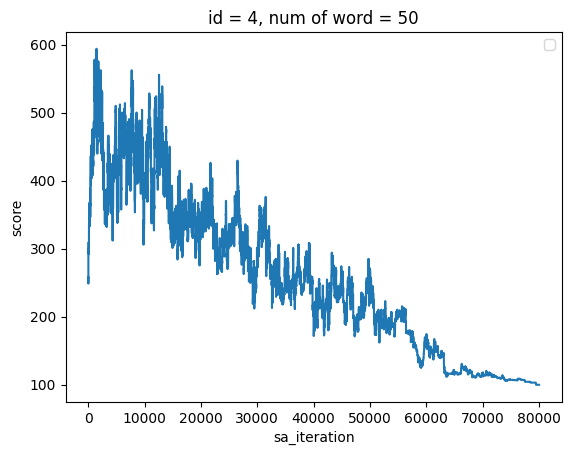

SA Score: 99.63988138921447


In [13]:
import matplotlib.pyplot as plt
plt.plot(log_scores)

plt.title(f'id = {4}, num of word = {len(text.split())}')
plt.xlabel('sa_iteration')
plt.ylabel('score')
plt.legend()
plt.show()

print(f'SA Score: {score_2}')


In [14]:
print(scorer.get_perplexity(solution), solution)

99.63988138921447 hohoho season merry have you cookie chocolate candy milk eggnog fruitcake peppermint candle snowglobe fireplace wreath poinsettia wish dream hope believe peace joy wonder night star angel greeting card wrapping paper bow kaggle workshop toy doll game puzzle the of and to in that from not it with as we


In [15]:
print(scorer.get_perplexity(most_best_text))

95.0770390179677


In [16]:
scorer.get_perplexity(' '.join(most_best_text.split()[:50]))

95.0770390179677

281.63868765896893 wreath fruitcake eggnog poinsettia snowglobe star cookie candy peppermint chocolate milk hohoho merry and joy to the season of peace wish you hope in it from we with card greeting paper wrapping bow candle fireplace toy doll angel night dream believe have wonder that not as game puzzle kaggle workshopn

# 3-3. Consideration 考察
Increasing the beam width will increase the search area and is expected to improve scores. You may want to experiment with different beam widths for different word counts.<br>
Another method, as with the greedy method, is to increase or change the pattern of words to be placed.
In the example implementation, an example of placement on the left is shown in the commented-out section.<br>

ビーム幅を大きくすると、さらに探索範囲が広がりスコアの改善が期待されます。単語数に合わせてビーム幅を変えて実験してみるのも良いでしょう。<br>
また、貪欲法の時と同じく、配置する単語の位置パターンを増やしたり変えてみる方法もあります。実装例では左に配置する例をコメントアウトで記載しています。

# 3-4. Submission 提出
Finally, let's submit the solutions.<br>
最後に、求めた解を提出してみましょう。